[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Depth Estimation Model-by-Model Comparision**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

This notebook is for comparing five Hugging Face depth-estimation models.

## Section A: Setup and Shared Utilities

Purpose:
- Define all reusable code only once.
- Keep the model execution cells short and easy to read.

Notes:
- `INFERENCE_MAX_SIDE` controls quality/speed tradeoff.
- `USE_FP16=True` helps on CUDA GPUs.


In [1]:
from __future__ import annotations

# Standard utilities
from contextlib import nullcontext
from dataclasses import dataclass
from math import ceil
from pathlib import Path
import time

# Third-party libraries used throughout the notebook
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# -------------------------------------------------------------------
# Global configuration
# -------------------------------------------------------------------
MODEL_IDS = [
    "Intel/zoedepth-nyu-kitti",
    "depth-anything/Depth-Anything-V2-Large-hf",
    "LiheYoung/depth-anything-large-hf",
    "Intel/dpt-hybrid-midas",
    "apple/DepthPro-hf",
]

# Visualization and performance settings
COLORMAP_NAME = "inferno"  # inferno | magma | plasma | viridis | turbo | gray
INFERENCE_MAX_SIDE = 640    # 0 keeps original resolution; smaller = faster
USE_FP16 = True             # CUDA only; ignored on CPU/MPS

# Supported OpenCV colormaps
COLORMAPS = {
    "inferno": cv2.COLORMAP_INFERNO,
    "magma": cv2.COLORMAP_MAGMA,
    "plasma": cv2.COLORMAP_PLASMA,
    "viridis": cv2.COLORMAP_VIRIDIS,
    "turbo": cv2.COLORMAP_TURBO,
    "gray": None,
}


def pick_device(device_name: str = "auto") -> torch.device:
    """Pick best available device unless explicitly overridden."""
    if device_name == "auto":
        if torch.cuda.is_available():
            return torch.device("cuda")
        if torch.backends.mps.is_available():
            return torch.device("mps")
        return torch.device("cpu")
    return torch.device(device_name)


def resize_for_inference(image_rgb: np.ndarray, max_side: int) -> np.ndarray:
    """Resize image before inference to reduce compute."""
    if max_side <= 0:
        return image_rgb
    h, w = image_rgb.shape[:2]
    longest = max(h, w)
    if longest <= max_side:
        return image_rgb
    scale = max_side / float(longest)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    return cv2.resize(image_rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)


def depth_to_uint8(depth: np.ndarray) -> np.ndarray:
    """Normalize depth map to [0, 255] uint8 for visualization.

    Handles NaN/Inf values that can appear on some frames/models.
    """
    depth = np.asarray(depth, dtype=np.float32)
    finite_mask = np.isfinite(depth)

    # If a frame is entirely invalid, emit a black depth map.
    if not finite_mask.any():
        return np.zeros(depth.shape, dtype=np.uint8)

    finite_vals = depth[finite_mask]
    depth_min = float(finite_vals.min())
    depth_max = float(finite_vals.max())

    # Guard against degenerate or non-finite ranges.
    if (not np.isfinite(depth_min)) or (not np.isfinite(depth_max)) or (depth_max - depth_min < 1e-8):
        return np.zeros(depth.shape, dtype=np.uint8)

    # Replace NaN/Inf before scaling to uint8.
    depth = np.nan_to_num(depth, nan=depth_min, posinf=depth_max, neginf=depth_min)
    depth_norm = (depth - depth_min) / (depth_max - depth_min)
    depth_norm = np.clip(depth_norm, 0.0, 1.0)
    return (depth_norm * 255.0).astype(np.uint8)
def colorize_depth(depth_u8: np.ndarray, colormap_name: str = COLORMAP_NAME) -> np.ndarray:
    """Convert single-channel depth to color for easier visual comparison."""
    cmap = COLORMAPS[colormap_name]
    if cmap is None:
        return cv2.cvtColor(depth_u8, cv2.COLOR_GRAY2BGR)
    return cv2.applyColorMap(depth_u8, cmap)


def bgr_to_rgb(image_bgr: np.ndarray) -> np.ndarray:
    """OpenCV loads BGR; matplotlib expects RGB."""
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


def show_image(title: str, image_bgr: np.ndarray, figsize=(7, 5)) -> None:
    """Display an OpenCV BGR image with matplotlib."""
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(bgr_to_rgb(image_bgr))
    plt.axis("off")
    plt.show()


@dataclass
class NotebookDepthRunner:
    """Load one model and expose a single prediction method."""

    model_id: str
    device: torch.device
    use_fp16: bool = False

    def __post_init__(self) -> None:
        # Load processor/model once; reuse for future calls.
        print(f"Loading model: {self.model_id} on {self.device}")
        self.processor = AutoImageProcessor.from_pretrained(self.model_id, trust_remote_code=True)
        model_dtype = torch.float16 if (self.use_fp16 and self.device.type == "cuda") else None
        self.model = AutoModelForDepthEstimation.from_pretrained(
            self.model_id,
            trust_remote_code=True,
            torch_dtype=model_dtype,
        ).to(self.device)
        self.model.eval()
        self.autocast_enabled = bool(self.use_fp16 and self.device.type == "cuda")

    def _extract_predicted_depth(self, outputs) -> torch.Tensor:
        # Handle both dataclass outputs and dict-like outputs.
        if hasattr(outputs, "predicted_depth"):
            return outputs.predicted_depth
        if isinstance(outputs, dict) and "predicted_depth" in outputs:
            return outputs["predicted_depth"]
        keys = list(outputs.keys()) if hasattr(outputs, "keys") else []
        raise RuntimeError(f"Model {self.model_id} did not return `predicted_depth`. Keys: {keys}")

    def predict_depth(self, frame_rgb: np.ndarray, out_hw: tuple[int, int]) -> np.ndarray:
        """Run inference and return depth map resized to original image size."""
        inputs = self.processor(images=frame_rgb, return_tensors="pt")
        inputs = {k: v.to(self.device, non_blocking=True) for k, v in inputs.items()}

        # Enable half precision only on CUDA when requested.
        if self.autocast_enabled:
            inputs = {k: (v.half() if torch.is_floating_point(v) else v) for k, v in inputs.items()}

        amp_ctx = (
            torch.autocast(device_type="cuda", dtype=torch.float16)
            if self.autocast_enabled
            else nullcontext()
        )

        with torch.inference_mode():
            with amp_ctx:
                outputs = self.model(**inputs)
                pred = self._extract_predicted_depth(outputs)

                # Normalize shape to [B, H, W].
                if pred.ndim == 2:
                    pred = pred.unsqueeze(0)
                if pred.ndim == 4:
                    pred = pred.squeeze(1)

                # Upsample to the requested output resolution.
                pred = F.interpolate(
                    pred.unsqueeze(1),
                    size=out_hw,
                    mode="bicubic",
                    align_corners=False,
                ).squeeze(1)

        return pred[0].detach().cpu().numpy()


# Pick runtime device and cache models as they are first used.
DEVICE = pick_device("auto")
if DEVICE.type == "cuda":
    torch.backends.cudnn.benchmark = True

print(f"Using device: {DEVICE}")

RUNNERS: dict[str, NotebookDepthRunner] = {}

def get_runner(model_id: str) -> NotebookDepthRunner:
    """Lazy-load model runner for the requested model id."""
    if model_id not in RUNNERS:
        RUNNERS[model_id] = NotebookDepthRunner(
            model_id=model_id,
            device=DEVICE,
            use_fp16=USE_FP16,
        )
    return RUNNERS[model_id]


def run_single_model(model_id: str, image_bgr: np.ndarray) -> tuple[np.ndarray, float]:
    """Run one model on one image and return (color_depth_map, elapsed_ms)."""
    h, w = image_bgr.shape[:2]

    # Convert once to RGB, then optionally downscale for speed.
    image_rgb = bgr_to_rgb(image_bgr)
    infer_rgb = resize_for_inference(image_rgb, INFERENCE_MAX_SIDE)

    runner = get_runner(model_id)
    t0 = time.perf_counter()
    depth = runner.predict_depth(infer_rgb, out_hw=(h, w))
    elapsed_ms = (time.perf_counter() - t0) * 1000.0

    # Convert raw depth to viewable color map.
    depth_u8 = depth_to_uint8(depth)
    depth_color = colorize_depth(depth_u8, COLORMAP_NAME)
    return depth_color, elapsed_ms


def load_reference_image(image_path: str | None, fallback_video: str = "assest/video/sample1.mp4") -> np.ndarray:
    """Load user image, or use first frame from a fallback video."""
    if image_path:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Could not read image: {image_path}")
        return image

    cap = cv2.VideoCapture(fallback_video)
    if not cap.isOpened():
        raise FileNotFoundError(
            f"No image_path set and fallback video cannot be opened: {fallback_video}"
        )
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Could not read first frame from fallback video: {fallback_video}")
    return frame


Using device: cuda


## Section B: Load the Shared Input Image

Purpose:
- Use one fixed image for all models so comparisons are fair.

Instructions:
- Set `IMAGE_PATH` to your own image.
- Leave it `None` to use the first frame from `assest/video/sample1.mp4`.


Input image shape: (3874, 5811, 3)


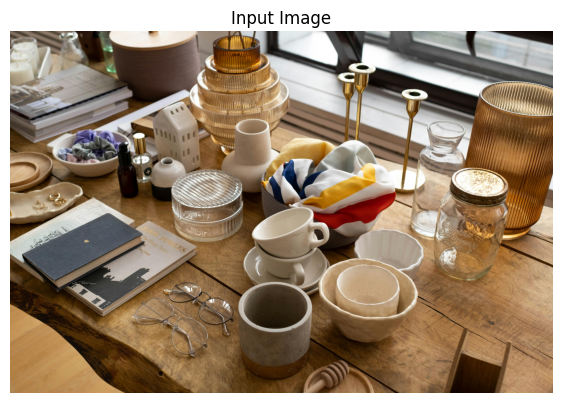

In [2]:
# Set your own image path here if you have one.
IMAGE_PATH = "assest/img1.jpg"

# Load a single input that every model will use.
input_bgr = load_reference_image(IMAGE_PATH)
print(f"Input image shape: {input_bgr.shape}")

# Visual check: confirm what image is being used.
show_image("Input Image", input_bgr)


## **Model 1: Intel/zoedepth-nyu-kitti**

ZoeDepth is commonly used when metric-scale consistency is important.


### Structured Model Information

> Snapshot note: values below are summarized from Hugging Face model cards/pages and may change with future revisions.

| Field | Value |
|---|---|
| **Model ID** | `Intel/zoedepth-nyu-kitti` |
| **Primary Task** | Monocular depth estimation |
| **Depth Output Type** | Metric-oriented depth (absolute scale behavior) |
| **Architecture** | ZoeDepth built on top of DPT |
| **Backbone Family** | Transformer/DPT-style backbone |
| **Training/Fine-tune Data** | Fine-tuned on **NYU + KITTI** |
| **Paper** | ZoeDepth: Zero-shot Transfer by Combining Relative and Metric Depth (`arXiv:2302.12288`) |
| **HF Reported Model Size** | ~**0.3B params** |
| **Checkpoint Size on HF** | ~**1.38 GB** (`model.safetensors`) |
| **License** | `MIT` |
| **Strengths** | Better metric-depth behavior than purely relative models; strong zero-shot usage |
| **Tradeoffs** | Heavier than lightweight baselines; can be slower |
| **Best Fit** | Robotics/AR/scene understanding where metric scale is useful |
| **Caution** | Still monocular estimation: absolute scale can drift on out-of-domain scenes |


Loading model: Intel/zoedepth-nyu-kitti on cuda


The image processor of type `ZoeDepthImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/647 [00:00<?, ?it/s]

Intel/zoedepth-nyu-kitti inference: 1759.6 ms


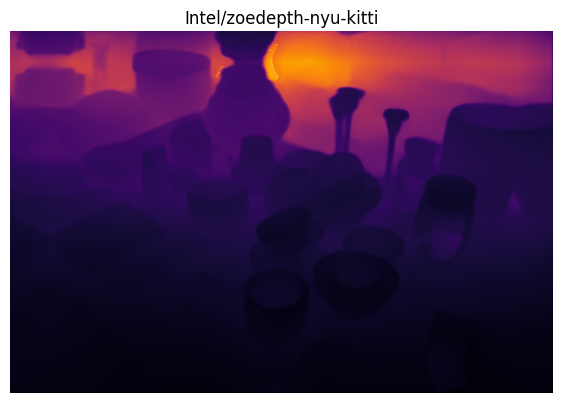

In [3]:
# -------------------------------------------------------------------
# Inference for: Intel/zoedepth-nyu-kitti
# -------------------------------------------------------------------
model_id = "Intel/zoedepth-nyu-kitti"

# Run one-model inference on the shared image.
depth_color, elapsed_ms = run_single_model(model_id, input_bgr)

# Report latency so you can compare speed across models.
print(f"{model_id} inference: {elapsed_ms:.1f} ms")

# Visualize this model's depth output.
show_image(model_id, depth_color)


## **Model 2: depth-anything/Depth-Anything-V2-Large-hf**

Depth Anything V2 Large is a strong, modern relative-depth model.


### Structured Model Information

> Snapshot note: values below are summarized from Hugging Face model cards/pages and may change with future revisions.

| Field | Value |
|---|---|
| **Model ID** | `depth-anything/Depth-Anything-V2-Large-hf` |
| **Primary Task** | Monocular depth estimation |
| **Depth Output Type** | Relative depth (this checkpoint) |
| **Architecture** | DPT-style decoder with DINOv2 backbone family |
| **Training Data Summary** | ~**595K synthetic labeled** + **62M+ real unlabeled** images |
| **Papers** | Depth Anything V2 (`arXiv:2406.09414`), Depth Anything (`arXiv:2401.10891`) |
| **HF Reported Model Size** | ~**0.3B params** |
| **Checkpoint Size on HF** | ~**1.34 GB** (`model.safetensors`) |
| **License** | `CC-BY-NC-4.0` (non-commercial) |
| **Strengths** | High visual quality, detailed edges, strong robustness vs many older baselines |
| **Tradeoffs** | Large model; higher latency/VRAM usage |
| **Best Fit** | High-quality relative-depth visualization and research comparisons |
| **Caution** | Non-commercial license restrictions apply |


Loading model: depth-anything/Depth-Anything-V2-Large-hf on cuda


The image processor of type `DPTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/503 [00:00<?, ?it/s]

depth-anything/Depth-Anything-V2-Large-hf inference: 400.2 ms


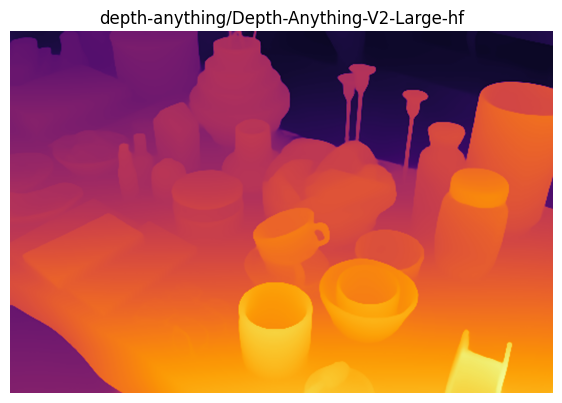

In [4]:
# -------------------------------------------------------------------
# Inference for: depth-anything/Depth-Anything-V2-Large-hf
# -------------------------------------------------------------------
model_id = "depth-anything/Depth-Anything-V2-Large-hf"

# Run one-model inference on the shared image.
depth_color, elapsed_ms = run_single_model(model_id, input_bgr)

# Report latency so you can compare speed across models.
print(f"{model_id} inference: {elapsed_ms:.1f} ms")

# Visualize this model's depth output.
show_image(model_id, depth_color)


## **Model 3: LiheYoung/depth-anything-large-hf**

Depth Anything v1 Large remains a reliable baseline in many pipelines.


### Structured Model Information

> Snapshot note: values below are summarized from Hugging Face model cards/pages and may change with future revisions.

| Field | Value |
|---|---|
| **Model ID** | `LiheYoung/depth-anything-large-hf` |
| **Primary Task** | Monocular depth estimation |
| **Depth Output Type** | Relative depth |
| **Architecture** | DPT architecture with DINOv2 backbone |
| **Training Data Summary** | Trained on ~**62M** images |
| **Paper** | Depth Anything: Unleashing the Power of Large-Scale Unlabeled Data (`arXiv:2401.10891`) |
| **HF Reported Model Size** | ~**0.3B params** |
| **Checkpoint Size on HF** | ~**1.34 GB** (`model.safetensors`) |
| **License** | `Apache-2.0` |
| **Strengths** | Strong general baseline, widely adopted in depth workflows |
| **Tradeoffs** | Usually less refined than V2 on difficult boundaries/details |
| **Best Fit** | Solid default baseline and compatibility with existing DA-v1 pipelines |
| **Caution** | Relative depth only; not direct metric-scale output |


Loading model: LiheYoung/depth-anything-large-hf on cuda


Loading weights:   0%|          | 0/503 [00:00<?, ?it/s]

LiheYoung/depth-anything-large-hf inference: 104.3 ms


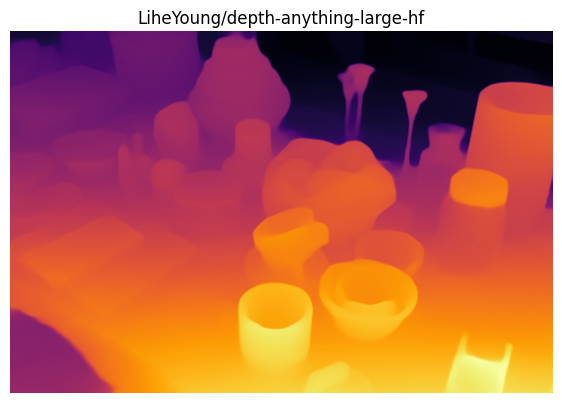

In [5]:
# -------------------------------------------------------------------
# Inference for: LiheYoung/depth-anything-large-hf
# -------------------------------------------------------------------
model_id = "LiheYoung/depth-anything-large-hf"

# Run one-model inference on the shared image.
depth_color, elapsed_ms = run_single_model(model_id, input_bgr)

# Report latency so you can compare speed across models.
print(f"{model_id} inference: {elapsed_ms:.1f} ms")

# Visualize this model's depth output.
show_image(model_id, depth_color)


## **Model 4: Intel/dpt-hybrid-midas**

DPT Hybrid MiDaS is a classic monocular depth baseline.


### Structured Model Information

> Snapshot note: values below are summarized from Hugging Face model cards/pages and may change with future revisions.

| Field | Value |
|---|---|
| **Model ID** | `Intel/dpt-hybrid-midas` |
| **Primary Task** | Monocular depth estimation |
| **Depth Output Type** | Relative depth |
| **Architecture** | DPT-Hybrid (MiDaS 3.0), ViT-hybrid backbone + depth head |
| **Training Data Summary** | MIX-6 dataset, ~**1.4M** images |
| **Paper** | Vision Transformers for Dense Prediction (`arXiv:2103.13413`) |
| **Checkpoint Size on HF** | ~**490 MB** (`pytorch_model.bin`) |
| **License** | `Apache-2.0` |
| **Strengths** | Mature, reliable, lighter than many new large models |
| **Tradeoffs** | Can miss fine boundaries/details compared to newer large models |
| **Best Fit** | Fast baseline checks, legacy projects, lower-resource setups |
| **Caution** | Output is relative depth and may need task-specific calibration |


Loading model: Intel/dpt-hybrid-midas on cuda


Loading weights:   0%|          | 0/414 [00:00<?, ?it/s]

Intel/dpt-hybrid-midas inference: 482.9 ms


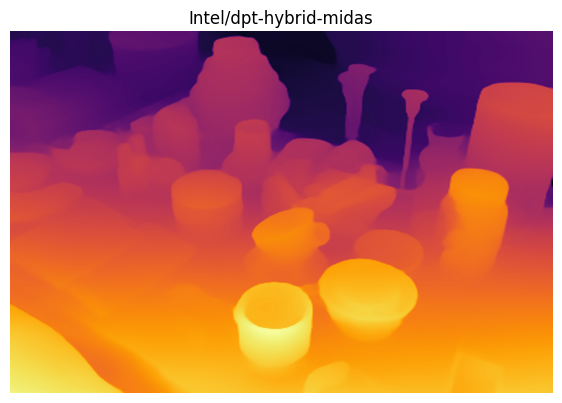

In [6]:
# -------------------------------------------------------------------
# Inference for: Intel/dpt-hybrid-midas
# -------------------------------------------------------------------
model_id = "Intel/dpt-hybrid-midas"

# Run one-model inference on the shared image.
depth_color, elapsed_ms = run_single_model(model_id, input_bgr)

# Report latency so you can compare speed across models.
print(f"{model_id} inference: {elapsed_ms:.1f} ms")

# Visualize this model's depth output.
show_image(model_id, depth_color)


## **Model 5: apple/DepthPro-hf**

DepthPro targets high-fidelity depth with strong local detail.


### Structured Model Information

> Snapshot note: values below are summarized from Hugging Face model cards/pages and may change with future revisions.

| Field | Value |
|---|---|
| **Model ID** | `apple/DepthPro-hf` |
| **Primary Task** | Zero-shot metric monocular depth estimation |
| **Depth Output Type** | Metric depth (absolute-scale oriented) |
| **Architecture** | Multi-scale ViT-based encoder + DPT-like feature fusion |
| **Extra Head** | Includes focal length / field-of-view estimation head |
| **Paper** | Depth Pro: Sharp Monocular Metric Depth in Less Than a Second (`arXiv:2410.02073`) |
| **HF Reported Model Size** | ~**1.0B params** |
| **Checkpoint Size on HF** | ~**1.9 GB** on current main checkpoint |
| **License** | HF metadata shows `apple-amlr` (some card revisions mention Apple-ASCL wording) |
| **Strengths** | High sharpness and strong boundary detail; metric-depth focus |
| **Tradeoffs** | Highest compute/memory demand among models in this notebook |
| **Best Fit** | Detail-sensitive evaluation where metric-depth behavior matters |
| **Caution** | Verify license terms carefully before production/commercial use |


Loading model: apple/DepthPro-hf on cuda


Loading weights:   0%|          | 0/1407 [00:00<?, ?it/s]

apple/DepthPro-hf inference: 11008.5 ms


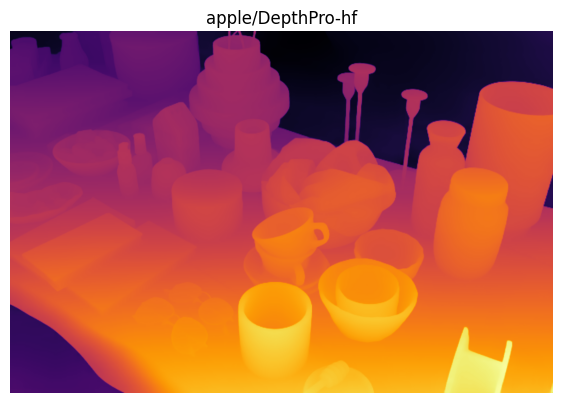

In [7]:
# -------------------------------------------------------------------
# Inference for: apple/DepthPro-hf
# -------------------------------------------------------------------
model_id = "apple/DepthPro-hf"

# Run one-model inference on the shared image.
depth_color, elapsed_ms = run_single_model(model_id, input_bgr)

# Report latency so you can compare speed across models.
print(f"{model_id} inference: {elapsed_ms:.1f} ms")

# Visualize this model's depth output.
show_image(model_id, depth_color)


## **Side-by-Side Image Comparison (All 5 Models)**


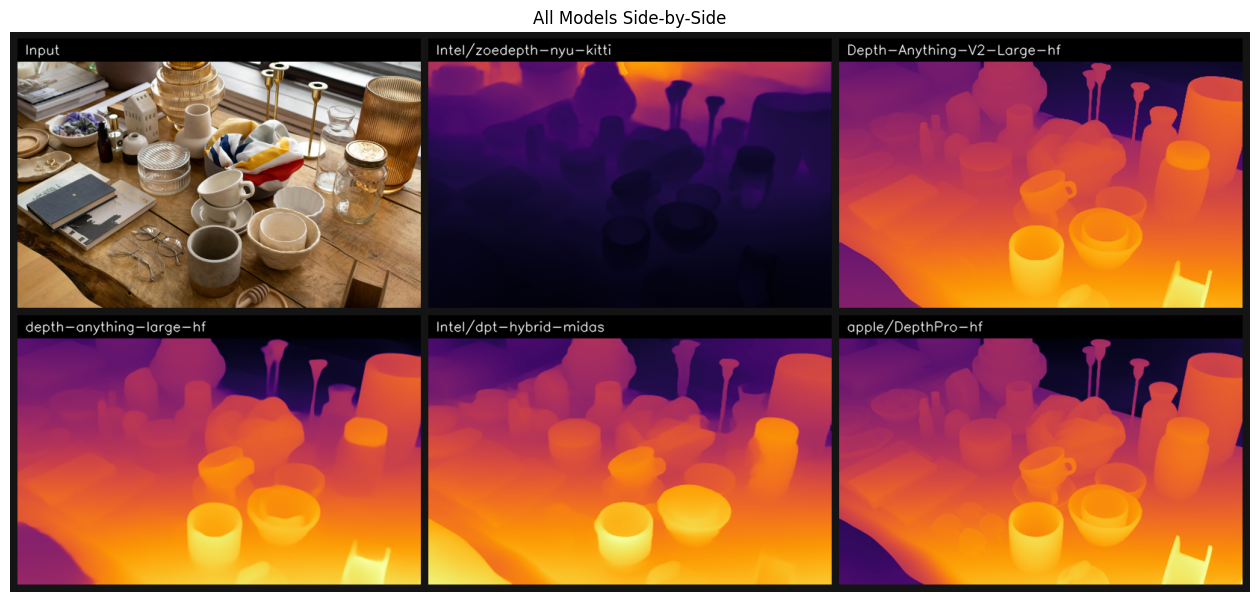

Inference timings (single image):
- Intel/zoedepth-nyu-kitti: 410.9 ms
- depth-anything/Depth-Anything-V2-Large-hf: 118.4 ms
- LiheYoung/depth-anything-large-hf: 90.9 ms
- Intel/dpt-hybrid-midas: 79.2 ms
- apple/DepthPro-hf: 1068.7 ms
Saved final comparison image to: result/notebook_depth_model_comparison.jpg


In [8]:
# Helper: resize panel for consistent visual layout.
def resize_for_panel(image: np.ndarray, max_side: int = 540) -> np.ndarray:
    if max_side <= 0:
        return image
    h, w = image.shape[:2]
    longest = max(h, w)
    if longest <= max_side:
        return image
    scale = max_side / float(longest)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


# Helper: shorten long model IDs for panel labels.
def short_model_name(model_id: str, max_chars: int = 30) -> str:
    if len(model_id) <= max_chars:
        return model_id
    tail = model_id.split("/")[-1]
    if len(tail) <= max_chars:
        return tail
    return tail[: max_chars - 3] + "..."


# Helper: draw a label strip on top of each panel.
def add_label(image: np.ndarray, text: str) -> np.ndarray:
    panel = image.copy()
    bar_h = min(36, max(24, panel.shape[0] // 12))
    cv2.rectangle(panel, (0, 0), (panel.shape[1], bar_h), (0, 0, 0), -1)
    cv2.putText(
        panel,
        text,
        (10, int(bar_h * 0.72)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (255, 255, 255),
        1,
        cv2.LINE_AA,
    )
    return panel


# Helper: pack panels into a grid.
def make_grid(panels: list[np.ndarray], cols: int = 3, pad: int = 8) -> np.ndarray:
    rows = ceil(len(panels) / cols)
    cell_h = max(panel.shape[0] for panel in panels)
    cell_w = max(panel.shape[1] for panel in panels)

    out_h = rows * cell_h + (rows + 1) * pad
    out_w = cols * cell_w + (cols + 1) * pad
    grid = np.full((out_h, out_w, 3), 20, dtype=np.uint8)

    for i, panel in enumerate(panels):
        r = i // cols
        c = i % cols
        y0 = pad + r * (cell_h + pad)
        x0 = pad + c * (cell_w + pad)

        h, w = panel.shape[:2]
        y = y0 + (cell_h - h) // 2
        x = x0 + (cell_w - w) // 2
        grid[y : y + h, x : x + w] = panel
    return grid


# Build panels: first input image, then each model output.
PANELS = [add_label(resize_for_panel(input_bgr), "Input")]
TIMINGS = {}

for model_id in MODEL_IDS:
    # Run depth inference and store per-model timing.
    depth_color, elapsed_ms = run_single_model(model_id, input_bgr)
    TIMINGS[model_id] = elapsed_ms

    # Add labeled depth panel for this model.
    panel = add_label(resize_for_panel(depth_color), short_model_name(model_id))
    PANELS.append(panel)

# Compose and display final grid.
comparison_bgr = make_grid(PANELS, cols=3, pad=10)
show_image("All Models Side-by-Side", comparison_bgr, figsize=(16, 10))

# Print timing summary for quick speed comparison.
print("Inference timings (single image):")
for model_id, t_ms in TIMINGS.items():
    print(f"- {model_id}: {t_ms:.1f} ms")

# Persist final result image for reports or sharing.
out_dir = Path("result")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "notebook_depth_model_comparison.jpg"
cv2.imwrite(str(out_path), comparison_bgr)
print(f"Saved final comparison image to: {out_path}")


## **Generate Comparison Video (All Models)**

Purpose:
- Run the same multi-model comparison pipeline on a full video.

How it works:
- Reads frames from `VIDEO_INPUT_PATH`.
- Runs all models on each frame using `run_single_model(...)`.
- Builds a labeled grid: `Input + 5 model outputs`.
- Writes to MP4 under `result/`.


In [9]:
# -------------------------------------------------------------------
# Video comparison generation
# -------------------------------------------------------------------
VIDEO_INPUT_PATH = "assest/video/video_001.mp4"
VIDEO_OUTPUT_DIR = "result"
VIDEO_OUTPUT_NAME = "video_001_depth_model_comparison.mp4"
VIDEO_GRID_COLS = 3
VIDEO_PANEL_MAX_SIDE = 540
VIDEO_MAX_FRAMES = 0     # 0 = process full video
VIDEO_FPS_OVERRIDE = 0.0 # 0 = use source video FPS


def build_comparison_frame(frame_bgr: np.ndarray, panel_max_side: int, grid_cols: int) -> tuple[np.ndarray, dict[str, float]]:
    """Create one labeled comparison frame and return timings per model."""
    panels = [add_label(resize_for_panel(frame_bgr, panel_max_side), "Input")]
    timings = {}

    for model_id in MODEL_IDS:
        depth_color, elapsed_ms = run_single_model(model_id, frame_bgr)
        timings[model_id] = elapsed_ms
        panel = add_label(resize_for_panel(depth_color, panel_max_side), short_model_name(model_id))
        panels.append(panel)

    comparison = make_grid(panels, cols=grid_cols, pad=10)
    return comparison, timings


# Open input video
cap = cv2.VideoCapture(VIDEO_INPUT_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {VIDEO_INPUT_PATH}")

src_fps = cap.get(cv2.CAP_PROP_FPS)
fps = VIDEO_FPS_OVERRIDE if VIDEO_FPS_OVERRIDE > 0 else (src_fps if src_fps > 0 else 30.0)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_dir = Path(VIDEO_OUTPUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / VIDEO_OUTPUT_NAME

writer = None
frame_idx = 0
agg_timings = {m: 0.0 for m in MODEL_IDS}

try:
    while True:
        if VIDEO_MAX_FRAMES > 0 and frame_idx >= VIDEO_MAX_FRAMES:
            break

        ok, frame_bgr = cap.read()
        if not ok:
            break

        comparison_frame, timings = build_comparison_frame(
            frame_bgr,
            panel_max_side=VIDEO_PANEL_MAX_SIDE,
            grid_cols=VIDEO_GRID_COLS,
        )

        if writer is None:
            h, w = comparison_frame.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*"mp4v")
            writer = cv2.VideoWriter(str(out_path), fourcc, fps, (w, h))
            if not writer.isOpened():
                raise RuntimeError(f"Could not open video writer: {out_path}")

        writer.write(comparison_frame)

        for model_id, t_ms in timings.items():
            agg_timings[model_id] += t_ms

        frame_idx += 1
        if frame_idx % 10 == 0:
            if total_frames > 0:
                print(f"Processed {frame_idx}/{total_frames} frames")
            else:
                print(f"Processed {frame_idx} frames")

finally:
    cap.release()
    if writer is not None:
        writer.release()

if frame_idx == 0:
    raise RuntimeError("No frames processed. Check video path and format.")

print(f"Saved comparison video to: {out_path}")
print(f"Processed frames: {frame_idx}")
print("Average per-model inference time (ms/frame):")
for model_id in MODEL_IDS:
    avg = agg_timings[model_id] / frame_idx
    print(f"- {model_id}: {avg:.1f} ms")


Processed 10/1811 frames
Processed 20/1811 frames
Processed 30/1811 frames
Processed 40/1811 frames
Processed 50/1811 frames
Processed 60/1811 frames
Processed 70/1811 frames
Processed 80/1811 frames
Processed 90/1811 frames
Processed 100/1811 frames
Processed 110/1811 frames
Processed 120/1811 frames
Processed 130/1811 frames
Processed 140/1811 frames
Processed 150/1811 frames
Processed 160/1811 frames
Processed 170/1811 frames
Processed 180/1811 frames
Processed 190/1811 frames
Processed 200/1811 frames
Processed 210/1811 frames
Processed 220/1811 frames
Processed 230/1811 frames
Processed 240/1811 frames
Processed 250/1811 frames
Processed 260/1811 frames
Processed 270/1811 frames
Processed 280/1811 frames
Processed 290/1811 frames
Processed 300/1811 frames
Processed 310/1811 frames
Processed 320/1811 frames
Processed 330/1811 frames
Processed 340/1811 frames
Processed 350/1811 frames
Processed 360/1811 frames
Processed 370/1811 frames
Processed 380/1811 frames
Processed 390/1811 fr

---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
